# Difftest Results

Connect to results database:

In [1]:
import db
from db import *

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [4]:
import pandas as pd

session = db.make_session()

indices, data = [], []
indices.append("Programs")
data.append((session.query(CLSmithProgram).count(),
             session.query(CLgenProgram).count()))
indices.append("Testbeds")
data.append((session.query(CLSmithResult.testbed).group_by(CLSmithResult.testbed).count(),
             session.query(CLgenResult.testbed).group_by(CLgenResult.testbed).count()))
indices.append("Params")
data.append((session.query(cl_launcherParams).count(), 
             session.query(cl_launcherParams).count()))
indices.append("Results")
data.append((session.query(CLSmithResult).count(),
             session.query(CLgenResult).count()))

pd.DataFrame(data, index=indices, columns=["CLSmith", "CLgen"])

,CLSmith,CLgen
Programs,10001,1000
Testbeds,2,2
Params,4,4
Results,80008,8000


### TestBeds

In [5]:
DEVICES = {
    "GeForce GTX 1080": "NVIDIA GTX 1080",
    "Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620"
}

testbeds = []
for testbed in session.query(Testbed):
    nresult_clsmith = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()
    nresult_clgen = session.query(CLgenResult).filter(CLgenResult.testbed == testbed).count()
    clsmith_ratio_result = "{:.2%}".format(nresult_clsmith / session.query(CLSmithResult).count())
    clgen_ratio_result = "{:.2%}".format(nresult_clgen / session.query(CLgenResult).count())
    testbeds.append((testbed.host, DEVICES.get(testbed.device, testbed.device),
                     testbed.driver, nresult_clsmith, clsmith_ratio_result,
                     nresult_clgen, clgen_ratio_result))
    
pd.DataFrame(testbeds, columns=[
    "Host", "Device", "Driver", "#. CLSmith Results", "CLSmith %", "#. CLgen Results", "CLgen %"],
            index=[testbed.id for testbed in session.query(Testbed)])

,Host,Device,Driver,#. CLSmith Results,CLSmith %,#. CLgen Results,CLgen %
3,Ubuntu 16.04 64bit,NVIDIA GTX 1080,375.39,40004,50.00%,4000,50.00%
9,Ubuntu 16.04 64bit,Intel E5-2620,1.2.0.25,40004,50.00%,4000,50.00%


## Runtimes

In [7]:
import numpy as np
clsmith_runtimes = np.array(session.query(CLSmithResult.runtime).filter(CLSmithResult.status == 0).all())
clgen_runtimes = np.array(session.query(CLgenResult.runtime).filter(CLgenResult.status == 0).all())

pd.DataFrame([
    (clsmith_runtimes.min(), clgen_runtimes.min()),
    (np.median(clsmith_runtimes), np.median(clgen_runtimes)),
    (clsmith_runtimes.mean(), clgen_runtimes.mean()),
    (clsmith_runtimes.max(), clgen_runtimes.max()),
], index=["Min", "Median", "Mean", "Max"], columns=["CLSmith", "CLgen"])

,CLSmith,CLgen
Min,0.122117,2.180390
Median,1.292730,5.874140
Mean,2.019824,4.262695
Max,58.667400,10.941300


### CLSmith Parameters

In [11]:
params, indices = [], []
q = session.query(cl_launcherParams).order_by(
        cl_launcherParams.gsize_x, cl_launcherParams.gsize_y, cl_launcherParams.gsize_z,
        cl_launcherParams.lsize_x, cl_launcherParams.lsize_y, cl_launcherParams.lsize_z,
        cl_launcherParams.optimizations)

for param in q:
    nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params == param).count()
    ratio_result = "{:.2%}".format(nresult_param / session.query(CLSmithResult).count())
    indices.append(param.id)
    params.append((param.gsize, param.lsize, param.optimizations_on_off, nresult_param, ratio_result))

pd.DataFrame(params, index=indices, columns=[
    "Global size", "Local size", "Optimizations", "#. of Results", "% of Total Results"])

,Global size,Local size,Optimizations,#. of Results,% of Total Results
4,"(1, 1, 1)","(1, 1, 1)",off,20002,25.00%
3,"(1, 1, 1)","(1, 1, 1)",on,20002,25.00%
2,"(128, 16, 1)","(32, 1, 1)",off,20002,25.00%
1,"(128, 16, 1)","(32, 1, 1)",on,20002,25.00%


### CLgen Parameters

In [12]:
params, indices = [], []
for param in session.query(cldriveParams).order_by(
        cldriveParams.size,
        cldriveParams.gsize_x, cldriveParams.gsize_y, cldriveParams.gsize_z,
        cldriveParams.lsize_x, cldriveParams.lsize_y, cldriveParams.lsize_z,
        cldriveParams.generator, cldriveParams.scalar_val, cldriveParams.optimizations):
    nresult_param = session.query(CLgenResult).filter(CLgenResult.params == param).count()
    ratio_result = "{:.2%}".format(nresult_param / session.query(CLgenResult).count())
    indices.append(param.id)
    params.append((param.size, param.generator, param.scalar_val, 
                   param.gsize, param.lsize, param.optimizations_on_off, 
                   nresult_param, ratio_result))

pd.DataFrame(params, index=indices, columns=[
    "Size", "Generator", "Scalar Val", "Global size", "Local size", "Optimizations", 
    "#. of Results", "% of Total Results"])

,Size,Generator,Scalar Val,Global size,Local size,Optimizations,#. of Results,% of Total Results
11,256,arange,None,"(1, 1, 1)","(1, 1, 1)",off,2000,25.00%
10,256,arange,None,"(1, 1, 1)","(1, 1, 1)",on,2000,25.00%
12,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",off,2000,25.00%
9,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",on,2000,25.00%


### CLSmith Exit Status

In [13]:
# set outcomes
session.rollback()
def get_outcome(result):
    if result.status == 1:
        prev = None
        for line in reversed(result.stderr.split('\n')):
            if line == "Error found (callback):":
                # Interpret CLSmith error callback messages:
                return prev.split()[0]
            elif line.startswith("Error"):
                # Interpret CLSmith error messages
                return {
                    "Error enqueueing kernel: -6": "CL_OUT_OF_HOST_MEMORY",
                    "Error sending finish command: -36": "CL_INVALID_COMMAND_QUEUE",
                    "Error building program: -11": "CL_BUILD_PROGRAM _FAILURE",
                    "Error creating kernel: -46": "CL_INVALID_KERNEL_NAME",
                    "Error enqueueing kernel: -5": "CL_OUT_OF_RESOURCES",
                }.get(line, line)
            prev = line
        else:
            raise LookupError
    else:
        # Interpret process status codes:
        return {
            -11: "Segmentation Fault",
            -9: "Timeout (60 seconds)",
            0: "z_Okay",
        }[result.status]

for result in session.query(CLSmithResult):
    result.outcome = get_outcome(result)
session.commit()
print("done.")

done.


In [14]:
import sqlalchemy as sql

outcomes = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.outcome, sql.func.count(CLSmithResult.outcome)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.outcome).order_by(sql.desc(sql.func.count(CLSmithResult.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        outcomes.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))

outcomes = pd.DataFrame(outcomes, columns=["Device", "Outcome", "Count", "% of Total Results"])
outcomes

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,32869,82.164284
1,NVIDIA GTX 1080,Timeout (60 seconds),3754,9.384062
2,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,2916,7.289271
3,NVIDIA GTX 1080,CL_INVALID_COMMAND_QUEUE,281,0.702430
4,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,102,0.254975
5,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,80,0.199980
6,NVIDIA GTX 1080,CL_INVALID_VALUE,2,0.005000
7,Intel E5-2620,z_Okay,28626,71.557844
8,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,6128,15.318468
9,Intel E5-2620,Timeout (60 seconds),3311,8.276672


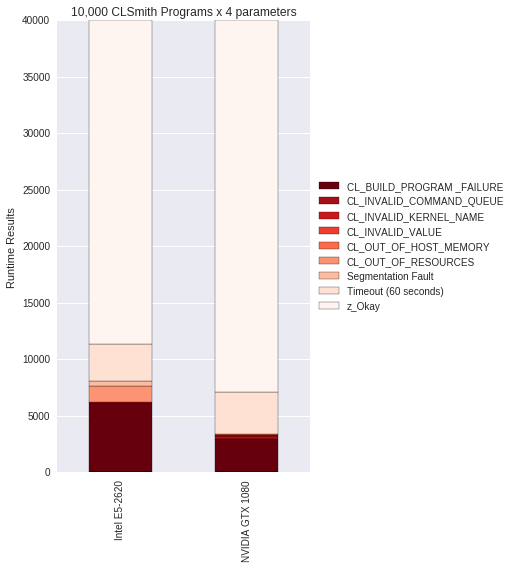

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

ax = outcomes.pivot('Device', 'Outcome')['Count'].plot(kind='bar', stacked=True, colormap="Reds_r")

plt.title("10,000 CLSmith Programs x 4 parameters")
plt.ylabel("Runtime Results")
plt.xlabel("")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0, 40000)

viz.finalise(figsize=(4.5, 8))

In [16]:
# for param in session.query(CLSmithParams).all():
#     suspicious = []

#     print("Params:", param)
#     programs_with_results = session.query(CLSmithProgram).filter(
#         CLSmithProgram.id.in_(session.query(CLSmithResult.program_id).filter(CLSmithResult.params_id == param.id)))
#     programs_with_good_results = session.query(CLSmithProgram).filter(
#         CLSmithProgram.id.in_(session.query(CLSmithResult.program_id).filter(
#             CLSmithResult.params_id == param.id, CLSmithResult.status == 0)))
#     ratio_good = programs_with_good_results.count() / programs_with_results.count()

#     print("  #. programs with results", programs_with_results.count())
#     print("  #. programs with good results", programs_with_good_results.count(), f"({ratio_good:.1%} of total)")

#     for program in programs_with_good_results.all():
#         q = session.query(CLSmithResult).filter(
#                 CLSmithResult.program_id == program.id, CLSmithResult.params_id == param.id)

#         stdout = set(r.stdout for r in q.all())
#         if len(stdout) > 1:
#             suspicious.append(q.first().program_id)

#     nsuspicious = len(suspicious)
#     ratio_suspicious = nsuspicious / programs_with_good_results.count()
#     print(f"  #. suspicious {nsuspicious} ({ratio_suspicious:.1%} of total)\n")

### CLgen Outcomes

In [17]:
import sqlalchemy as sql

outcomes = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLgenResult).filter(CLgenResult.testbed == testbed).count()

    q = session.query(CLgenResult.status, sql.func.count(CLgenResult.status)).filter(
        CLgenResult.testbed == testbed).group_by(CLgenResult.status).order_by(
            sql.desc(sql.func.count(CLgenResult.status)))

    for status, count in q.all():
        ratio = (count / nresult) * 100
        outcomes.append((DEVICES.get(testbed.device, testbed.device), status, count, ratio))

outcomes = pd.DataFrame(outcomes, columns=["Device", "Status", "Count", "% of Total Results"])
outcomes

,Device,Status,Count,% of Total Results
0,NVIDIA GTX 1080,0,3994,99.85
1,NVIDIA GTX 1080,1,6,0.15
2,Intel E5-2620,0,3984,99.60
3,Intel E5-2620,1,16,0.40


In [19]:
# set outcomes
session.rollback()
def get_clgen_outcome(result):
    if result.status == 1:
        line = result.stderr.split('\n')[-2]  # last line contains the error
        return {
            "cldrive.driver.PorcelainError: SIGSEGV": "Segmentation Fault",
            "pyopencl.cffi_cl.LogicError: clWaitForEvents failed: <unknown error -9999>": "clWaitForEvents()",
        }.get(line, line)
        return 
    else:
        # Interpret process status codes:
        return {
            -11: "Segmentation Fault",
            -9: "Timeout (60 seconds)",
            0: "z_Okay",
        }[result.status]

for result in session.query(CLgenResult):
    result.outcome = get_clgen_outcome(result)
session.commit()
print("done.")

done.


In [20]:
clgen_outcomes = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLgenResult).filter(CLgenResult.testbed == testbed).count()

    q = session.query(CLgenResult.outcome, sql.func.count(CLgenResult.outcome)).filter(
        CLgenResult.testbed == testbed).group_by(CLgenResult.outcome).order_by(
            sql.desc(sql.func.count(CLgenResult.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        clgen_outcomes.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))

clgen_outcomes = pd.DataFrame(clgen_outcomes, columns=["Device", "Outcome", "Count", "% of Total Results"])
clgen_outcomes

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,3994,99.85
1,NVIDIA GTX 1080,clWaitForEvents(),6,0.15
2,Intel E5-2620,z_Okay,3984,99.60
3,Intel E5-2620,Segmentation Fault,16,0.40


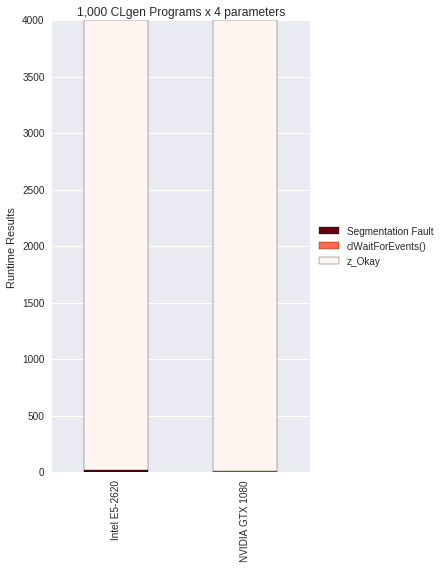

In [21]:
ax = clgen_outcomes.pivot('Device', 'Outcome')['Count'].plot(kind='bar', stacked=True, colormap="Reds_r")

plt.title("1,000 CLgen Programs x 4 parameters")
plt.ylabel("Runtime Results")
plt.xlabel("")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0, 4000)

viz.finalise(figsize=(4.5, 8))

In [22]:
q = session.query(CLgenResult).filter(CLgenResult.outcome == "Segmentation Fault")
for r in q:
    print(r.program_id)
    print(r.program.src)

10c7f08da79a0cd3bd21cdde97230b97fba88b0e
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);
  int f = get_global_id(1);
  int g = f + c;
  int h = e + f * g;

  a[h] = 1.0f - (d + 1);
}
2ebfceb149c46a6b3946cc5876e9b661c5bcf5c5
__kernel void A(__global float* a, __global float* b, __global float* c, __global float* d, const int e) {
  const int f = get_global_id(0);
  const int g = get_global_id(1);

  if (f < d && g < d) {
    float h = b[g];
    float i = b[f];

    a[e] = h;
    a[f] = h;
  }
}
4718a764ce95c1d7461674689cf841762fa1fafc
__kernel void A(__global float* a, __global float* b, __global float* c, __global float* d, const int e) {
  const int f = get_global_id(0);
  const int g = get_global_id(1);

  if (f < d - 1) {
    b[g * e + f] = -1;
  }
}
572b4181d340c5328be9000a3e4c247243a4f411
__kernel void A(__global float* a, __global float* b, __global float* c, __global float* d, const int e) {
  const int f = get_